In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

2025-08-16 10:33:23.238428: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1755340403.491151      89 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1755340403.564087      89 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


Train: (60000, 784) (60000,)
Test: (10000, 784) (10000,)
normalized_images shape:- (5923, 64)
shape 4:- (5923, 64, 64)
normalized_images shape:- (6742, 64)
shape 4:- (6742, 64, 64)
normalized_images shape:- (5958, 64)
shape 4:- (5958, 64, 64)
normalized_images shape:- (6131, 64)
shape 4:- (6131, 64, 64)
normalized_images shape:- (5842, 64)
shape 4:- (5842, 64, 64)
normalized_images shape:- (5421, 64)
shape 4:- (5421, 64, 64)
normalized_images shape:- (5918, 64)
shape 4:- (5918, 64, 64)
normalized_images shape:- (6265, 64)
shape 4:- (6265, 64, 64)
normalized_images shape:- (5851, 64)
shape 4:- (5851, 64, 64)
normalized_images shape:- (5949, 64)
shape 4:- (5949, 64, 64)


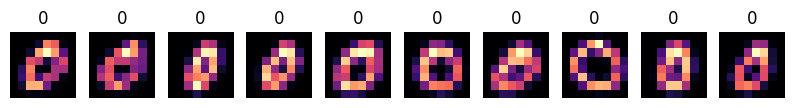

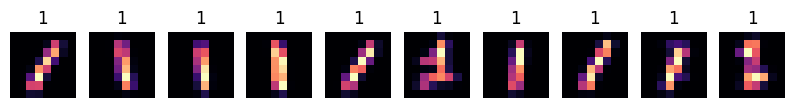

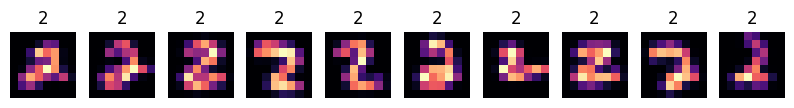

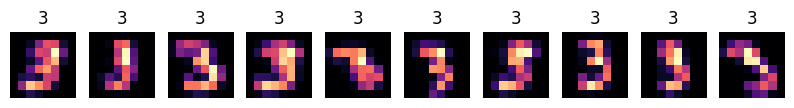

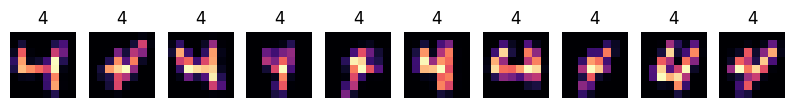

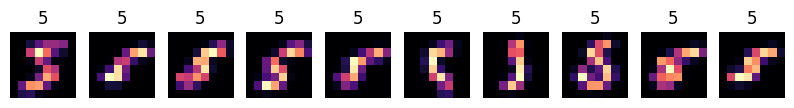

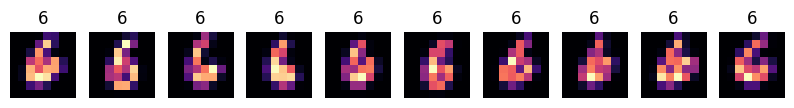

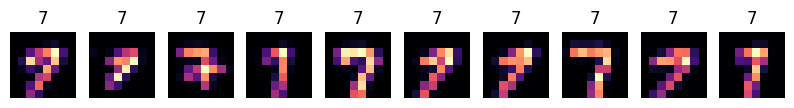

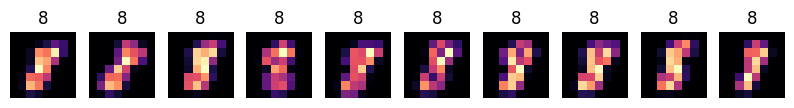

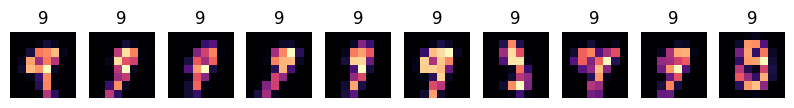

normalized_Hermitian_Digit_matrices shape:- torch.Size([60000, 64, 64])
normalized_hermitian_matrices_test_input shape:- torch.Size([10000, 64, 64])
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9]


In [1]:
# Data Preprocessing of the MNIST Dataset to produce the train and test normalized Hamiitonians...
# We can construct the hamiltonians from the four methods described in the paper...
import numpy as np
from skimage.transform import resize
import matplotlib.pyplot as plt
from PIL import Image
import torch
from sklearn.datasets import fetch_openml
import scipy

# ----------------------------
# Load MNIST from OpenML
# ----------------------------
# mnist = fetch_openml('mnist_784', version=1, as_frame=False)

# mnist_images = mnist.data.astype(np.float64)   # (70000, 784)
# mnist_labels = mnist.target.astype(int)        # (70000,)

# x_train = mnist_images[:60000]
# y_train = mnist_labels[:60000]
# x_test  = mnist_images[60000:60201]
# y_test  = mnist_labels[60000:60201]

#OR

from tensorflow.keras.datasets import mnist

# Load MNIST using Keras
(x_train, y_train), (x_test, y_test) = mnist.load_data()

# # Reshape and convert to float64 for consistency
x_train = x_train.reshape(-1, 784).astype(np.float64)
x_test = x_test.reshape(-1, 784).astype(np.float64)
print("Train:", x_train.shape, y_train.shape)
print("Test:", x_test.shape, y_test.shape)

# ----------------------------
# Helper functions
# ----------------------------
def separate_digits(images, labels):
    """Group images by digit label."""
    digit_image = {d: [] for d in range(10)}
    for img, lbl in zip(images, labels):
        digit_image[lbl].append(img)
    return digit_image

def resize_images_batch(images, new_size=(8, 8), batch_size=500):
    """Resize a batch of flattened 28x28 images to new_size."""
    n = len(images)
    resized = []
    for i in range(0, n, batch_size):
        batch = images[i:i+batch_size]
        resized_batch = [resize(img.reshape(28,28), new_size).flatten() for img in batch]
        resized.extend(resized_batch)
    return np.array(resized)

def normalize_batch(images):
    """Normalize each image vector."""
    norms = np.linalg.norm(images, axis=1, keepdims=True)
    return images / norms

#Creating Hamiltonian using outer product method
def density_matrix_batch(images):
    """Convert vectors to density matrices."""
    return np.matmul(images[:,:,np.newaxis], images[:,np.newaxis,:])

#Creating the Hamiltonian using H = A + A.T/2 method
def hamiltonian_symmetric_batch(images):
  N,D = images.shape
  H_list = []
  for i in range(N):
    a = images[i]
    A = np.outer(a,np.ones(D))
    H = (A + A.conj().T) / 2
    H_list.append(H)

  return np.array(H_list)

#Creating the Hamiltonian using H = A @ A.T method
def hamiltonian_product_batch(images):
  N , D = images.shape
  H_list = []
  for i in range(N):
    a = images[i]
    A = np.outer(a,np.ones(D))
    H = A @ A.T
    H_list.append(H)
  return np.array(H_list)

import scipy.linalg
#Creating thr Hamiltonian using H = -i * log(V) method
def hamiltonian_using_log(images):
    # def make_unitary1(matrix):
    #     U, _, Vh = torch.linalg.svd(matrix, full_matrices=False)
    #     return U @ Vh
    
    # def make_unitary2(matrix):
    #     matrix = matrix / (torch.linalg.norm(matrix) + 1e-12) #for -i log(V) case only
    #     Q,R = torch.linalg.qr(matrix)
    #     return Q
            
    # N , D = images.shape
    # hamiltonians = np.zeros((N,D,D), dtype = np.complex128)
    # for i in range(N):
    #     image = images[i]
    #     mat = np.diag(image)
    #     mat_torch = torch.tensor(mat,dtype = torch.complex128)
    #     U_torch = make_unitary2(mat_torch)
    #     U_np = U_torch.detach().cpu().numpy()
    #     H = -1j * scipy.linalg.logm(U_np)
    #     H = (H + H.conj().T) / 2
    #     hamiltonians[i] = H

    # return hamiltonians
    def _make_hermitian(M):
        return 0.5 * (M + M.conj().transpose(-2,-1))

    def _make_unitary(M):
        H = _make_hermitian(M)
        return torch.matrix_exp(-1j*H)

    N,D = images.shape
    hamiltonians = np.zeros((N,D,D),dtype = np.complex128)
    for i in range(N):
        image = images[i]
        mat = np.diag(image)
        mat_torch = torch.tensor(mat,dtype = torch.complex128)
        H = _make_unitary(mat_torch)
        hamiltonians[i] = H
    return hamiltonians
        

    
        

# ----------------------------
# Process training data
# ----------------------------
digit_images_dict = separate_digits(x_train, y_train)
resized_digit_images = {}
normalized_digit_images = {}
density_matrices = {}

for digit, imgs in digit_images_dict.items():
    imgs = np.array(imgs)
    imgs_resized = resize_images_batch(imgs, new_size=(8,8), batch_size=500)
    imgs_normalized = normalize_batch(imgs_resized)
    print(f"normalized_images shape:- {imgs_normalized.shape}")
    # density1 = density_matrix_batch(imgs_normalized)
    # print(f"shape 1:- {density1.shape}")
    #OR
    #density2 = hamiltonian_symmetric_batch(imgs_normalized)
    #print(f"shape 2:- {density2.shape}")
    #OR
    #density3 = hamiltonian_product_batch(imgs_normalized)
    #print(f"shape 3:- {density3.shape}")
    #OR
    density4 = hamiltonian_using_log(imgs_normalized)
    print(f"shape 4:- {density4.shape}")
    #density1 /= np.linalg.norm(density1, axis=(1,2), keepdims=True)
    #density2 /= np.linalg.norm(density2, axis=(1,2), keepdims=True)
    #density3 /= np.linalg.norm(density3, axis=(1,2), keepdims=True)
    density4 /= np.linalg.norm(density4, axis=(1,2), keepdims=True)
    resized_digit_images[digit] = imgs_resized
    normalized_digit_images[digit] = imgs_normalized
    #density_matrices[digit] = density1
    #density_matrices[digit] = density2
    #density_matrices[digit] = density3
    density_matrices[digit] = density4

train_density_matrices = np.concatenate([density_matrices[d] for d in range(10)], axis=0)
train_density_matrices_tensor = torch.tensor(train_density_matrices, dtype=torch.cfloat)

# ----------------------------
# Process test data
# ----------------------------
test_images_resized = np.array([resize(img.reshape(28,28), (8,8)).flatten() for img in x_test])
test_normed = normalize_batch(test_images_resized)
test_density = density_matrix_batch(test_normed)
test_density /= np.linalg.norm(test_density, axis=(1,2), keepdims=True)
test_density_tensor = torch.tensor(test_density, dtype=torch.cfloat)

# ----------------------------
# Visualization example
# ---------------------------

for digit in range(10):
    images_to_plot = resized_digit_images[digit][:10]
    plt.figure(figsize=(10,2))
    for i in range(10):
        plt.subplot(1, 10, i+1)
        plt.imshow(images_to_plot[i].reshape(8,8), cmap='magma')
        plt.title(f"{digit}")
        plt.axis('off')
    plt.show()

normalized_Hermitian_Digit_matrices = train_density_matrices_tensor
# normalized_Hermitian_Digit_matrices = torch.tensor(train_subset,dtype = torch.cfloat)
normalized_hermitian_matrices_test_input = test_density_tensor
# normalized_hermitian_matrices_test_input = torch.tensor(test_subset,dtype = torch.cfloat)

print(f"normalized_Hermitian_Digit_matrices shape:- {normalized_Hermitian_Digit_matrices.shape}")
print(f"normalized_hermitian_matrices_test_input shape:- {normalized_hermitian_matrices_test_input.shape}")
# normalized_Hermitian_Digit_matrices_small = torch.tensor(train_subset_small,dtype = torch.cfloat)
# normalized_hermitian_matrices_test_input_small = torch.tensor(test_subset_small,dtype = torch.cfloat)


labels = []
for i in range(10):
    labels.append(i)

print(labels)

D = [5923, 6742, 5958, 6131, 5842, 5421, 5918, 6265, 5851, 5949]
# D = [100] * 10
labels_zero = [labels[0]]*D[0]
labels_one  = [labels[1]]*D[1]
labels_two  = [labels[2]]*D[2]
labels_three  = [labels[3]]*D[3]
labels_four  = [labels[4]]*D[4]
labels_five  = [labels[5]]*D[5]
labels_six  = [labels[6]]*D[6]
labels_seven  = [labels[7]]*D[7]
labels_eigth  = [labels[8]]*D[8]
labels_nineth  = [labels[9]]*D[9]
labels_zero = np.array(labels_zero,dtype = int)
labels_one = np.array(labels_one,dtype = int)
labels_two = np.array(labels_two,dtype = int)
labels_three = np.array(labels_three,dtype = int)
labels_four = np.array(labels_four,dtype = int)
labels_five = np.array(labels_five,dtype = int)
labels_six = np.array(labels_six,dtype = int)
labels_seven = np.array(labels_seven,dtype = int)
labels_eigth = np.array(labels_eigth,dtype = int)
labels_nineth = np.array(labels_nineth,dtype = int)

labels_new_train = np.concatenate((labels_zero,labels_one))
labels_new_train = np.concatenate((labels_new_train,labels_two))
labels_new_train = np.concatenate((labels_new_train,labels_three))
labels_new_train = np.concatenate((labels_new_train,labels_four))
labels_new_train = np.concatenate((labels_new_train,labels_five))
labels_new_train = np.concatenate((labels_new_train,labels_six))
labels_new_train = np.concatenate((labels_new_train,labels_seven))
labels_new_train = np.concatenate((labels_new_train,labels_eigth))
labels_new_train = np.concatenate((labels_new_train,labels_nineth))


Approach 1

In [4]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
from torch.utils.data import DataLoader, TensorDataset

class MatrixModel(nn.Module):
  def __init__(self,num_classes = 10, matrix_size = 64):
    super().__init__()
    self.num_classes = num_classes
    self.matrix_size = matrix_size
    self.eigenvalues = nn.Parameter(torch.randn(num_classes,matrix_size,dtype = torch.float64))
    self.eigenvectors_real = nn.Parameter(torch.randn(num_classes,matrix_size,matrix_size,dtype = torch.float64))
    self.eigenvectors_imag = nn.Parameter(torch.randn(num_classes,matrix_size,matrix_size,dtype = torch.float64))

  def get_complex_eigenvectors(self):
    return torch.complex(self.eigenvectors_real, self.eigenvectors_imag)

  def find_unitary_transformation(self,input_density_matrix, output_density_matrix):
    X = np.dot(output_density_matrix, np.linalg.pinv(input_density_matrix))
    U, S, V_dagger = np.linalg.svd(X, full_matrices=False)
    phase_matrix = np.diag(np.exp(1j * np.angle(S)))
    unitary_matrix = U @ (phase_matrix @ V_dagger)
    unitary_matrix /= np.linalg.det(unitary_matrix)**(1/2)
    return unitary_matrix

  def is_unitary(matrix):
    # Check if the matrix is unitary
    identity = np.eye(matrix.shape[0])
    return np.allclose(matrix @ matrix.conj().T, identity) and np.allclose(matrix.conj().T @ matrix, identity)


    
  def make_unitary1(self,matrix):
    U,_,Vh = torch.linalg.svd(matrix,full_matrices = False)
    return U @ Vh

  def make_unitary2(self,matrix):
    matrix = matrix / (torch.linalg.norm(matrix) + 1e-12) #for -i log(V) case only
    Q,R = torch.linalg.qr(matrix)
    return Q

  def make_unitary3(self,matrix):
    # Lower triangular density matrix
    matrix = matrix.detach().cpu().numpy()
    input_density_matrix = np.zeros((64, 64), dtype=np.complex128)
    input_density_matrix[0, 0] = 1.0
    lower_triangular = np.tril(matrix)
    lower_triangular_conj = np.conj(lower_triangular).T
    Density_Matrix_Classical_Lower = lower_triangular + lower_triangular_conj
    return torch.tensor(Density_Matrix_Classical_Lower,dtype = torch.complex128)

  def make_unitary4(self, matrix):
    U, P = torch.linalg.polar(matrix)  # U is unitary
    return U


    # Upper triangular density matrix
    upper_triangular = np.triu(matrix)
    upper_triangular_conj = np.conj(upper_triangular).T
    Density_Matrix_Classical_Upper = upper_triangular + upper_triangular_conj

    # Halve diagonal elements
    np.fill_diagonal(Density_Matrix_Classical_Lower,
                     Density_Matrix_Classical_Lower.diagonal() / 2)
    np.fill_diagonal(Density_Matrix_Classical_Upper,
                     Density_Matrix_Classical_Upper.diagonal() / 2)

    # Normalize by trace
    Density_Matrix_Classical_Lower_Normalized = (
        Density_Matrix_Classical_Lower / np.trace(Density_Matrix_Classical_Lower)
    )
    Density_Matrix_Classical_Upper_Normalized = (
        Density_Matrix_Classical_Upper / np.trace(Density_Matrix_Classical_Upper)
    )

    # Find unitary transformations
    unitary_transformation_lower = self.find_unitary_transformation(
        input_density_matrix, Density_Matrix_Classical_Lower_Normalized
    )
    unitary_transformation_upper = self.find_unitary_transformation(
        input_density_matrix, Density_Matrix_Classical_Upper_Normalized
    )

    # Choose one — here we return the lower version
    # return unitary_transformation_lower
    return torch.from_numpy(unitary_transformation_lower).to(torch.complex128)
  

    
      

  
  def get_hamiltonians_orig1(self):
        eigenvectors_complex = self.get_complex_eigenvectors()
        unitary_vecs = torch.stack([self.make_unitary1(mat) for mat in eigenvectors_complex])
        diag_matrices = torch.diag_embed(self.eigenvalues.to(torch.complex128))
        hamiltonians = unitary_vecs @ diag_matrices @ unitary_vecs.conj().transpose(-1, -2)
        hamiltonians = (hamiltonians + hamiltonians.conj().transpose(-1, -2)) / 2
        return hamiltonians
  
  def get_hamiltonians_orig2(self):
        eigenvectors_complex = self.get_complex_eigenvectors()
        unitary_vecs = torch.stack([self.make_unitary2(mat) for mat in eigenvectors_complex])
        diag_matrices = torch.diag_embed(self.eigenvalues.to(torch.complex128))
        hamiltonians = unitary_vecs @ diag_matrices @ unitary_vecs.conj().transpose(-1, -2)
        hamiltonians = (hamiltonians + hamiltonians.conj().transpose(-1, -2)) / 2
        return hamiltonians
  
  def get_hamiltonians_orig3(self):
        eigenvectors_complex = self.get_complex_eigenvectors()
        unitary_vecs = torch.stack([self.make_unitary3(mat) for mat in eigenvectors_complex])
        diag_matrices = torch.diag_embed(self.eigenvalues.to(torch.complex128))
        hamiltonians = unitary_vecs @ diag_matrices @ unitary_vecs.conj().transpose(-1, -2)
        hamiltonians = (hamiltonians + hamiltonians.conj().transpose(-1, -2)) / 2
      
        return hamiltonians

    



  def forward(self):
    return self.get_hamiltonians_orig3() #OR get_hamiltonians_orig2,get_hamiltonians_orig3

def combined_loss_batched(output, target_batch, labels_batch):
  batch_size = target_batch.size(0)
  class_hamiltonians = output[labels_batch]
  # print(class_hamiltonians.shape)
  # print(target_batch.shape)
  # diff = torch.nan_to_num(class_hamiltonians - target_batch,nan = 0.0,posinf = 1e6,neginf = -1e6)
  # losses = torch.linalg.norm(diff,dim = (1,2))  
  losses = torch.linalg.norm(class_hamiltonians - target_batch,dim = (1,2))
  return torch.mean(losses)

def combined_loss_batched2(output, target_batch, labels_batch):
    batch_size = target_batch.size(0)

    # Differentiable class selection
    class_hamiltonians = torch.gather(
        output, 1, labels_batch.view(-1, 1, 1, 1).expand(-1, 1, 64, 64)
    ).squeeze(1)

    # Convert target to Hamiltonian form
    target_batch = target_batch.reshape(batch_size, -1)  # (n, 64)
    target_batch = torch.einsum('bi,bj->bij', target_batch, target_batch.conj())  # (n, 64, 64)

    losses = torch.linalg.norm(class_hamiltonians - target_batch, dim=(1, 2))
    return torch.mean(losses)


def create_labels_from_class_counts(class_counts):
    labels = []
    for class_idx, count in enumerate(class_counts):
        labels.extend([class_idx] * count)
    return labels

def create_batched_data(data, labels, batch_size=64):
    if not isinstance(data, torch.Tensor):
        if isinstance(data, list) and len(data) > 0:
            data = torch.stack(data)
        else:
            data = torch.tensor(data)
    if not isinstance(labels, torch.Tensor):
        labels = torch.tensor(labels)
    if not data.dtype == torch.complex128:
        data = data.to(torch.complex128)
    dataset = TensorDataset(data, labels)
    dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

    return dataloader

def train_model(model, dataloader,optimizer, scheduler, threshold = 0.0000001, num_epochs=100):
    model.train()
    all_losses = []
    wait = 0
    patience = 5
    to_stop = 0
    epoch = 0
    for epoch in range(num_epochs):
        print(f"Epoch:- {epoch}")
        total_loss = 0.0
        num_batches = 0

        for batch_data, batch_labels in dataloader:
            if num_batches % 1000 == 0:
              print(num_batches)
            batch_data = batch_data.to(device)
            batch_labels = batch_labels.to(device)
            optimizer.zero_grad()
            outputs = model()
            loss = combined_loss_batched(outputs, batch_data, batch_labels)
            loss.backward()
            optimizer.step()

            total_loss += loss.item()
            num_batches += 1

        avg_loss = total_loss / num_batches
        scheduler.step(avg_loss)
        diff = 0
        if epoch > 2:
          diff = all_losses[-1] - avg_loss
        all_losses.append(avg_loss)
        if epoch > 2 and avg_loss - all_losses[-1] < threshold:
          print("less than threshold")
          if wait < patience:
            wait = wait + 1
          else:
            to_stop = 1
        if epoch % 1 == 0:
            print(f'Epoch [{epoch}/{num_epochs}], Average Loss: {avg_loss:.4e}, Difference = {diff:.10e}')
        epoch = epoch + 1

    print("Training completed!")

def inference(model, test_data, test_labels=None):
    model.eval()

    with torch.no_grad():
        hamiltonians = model().cpu() # 10,64,64
        # print(hamiltonians.shape)
        predicted_labels = []

        for test_sample in test_data:
            if isinstance(test_sample, torch.Tensor):
                test_sample = test_sample.cpu()
            frobenius_norms = []
            for class_idx in range(10):
                # print(test_sample.shape)
                # print(hamiltonians[class_idx].shape)
                norm = torch.linalg.norm(test_sample - hamiltonians[class_idx], ord='fro')
                frobenius_norms.append(norm.item())
            predicted_labels.append(np.argmin(frobenius_norms))
        if test_labels is not None:
            accuracy = np.sum(np.array(predicted_labels) == np.array(test_labels))
            accuracy_percent = (accuracy / len(test_labels)) * 100
            return predicted_labels, accuracy_percent

        return predicted_labels

In [5]:
import scipy

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

print("Creating the training data and labels")
class_counts = [5923, 6742, 5958, 6131, 5842, 5421, 5918, 6265, 5851, 5949]
# class_counts = [100] * 10
training_labels = create_labels_from_class_counts(class_counts)
training_data = torch.as_tensor(normalized_Hermitian_Digit_matrices,dtype = torch.complex128,device = device)
print(f"training data shape:- {training_data.shape}")
# training_data_small = torch.as_tensor(normalized_Hermitian_Digit_matrices_small.view(-1,8,8))
# print(f"training data small shape:- {training_data_small.shape}")


print("Initialising the model,optimier,scheduler")
model = MatrixModel(num_classes = 10,matrix_size = 64).to(device)
optimizer = optim.Adam(model.parameters(), lr=0.01, weight_decay=1e-5)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, factor=0.5, patience=10)
batch_size = 500

dataloader = create_batched_data(training_data, training_labels, batch_size=batch_size)
# dataloader_small = create_batched_data(training_data_small,training_labels,batch_size = batch_size)

print(f"Training with {len(dataloader)} batches of size {batch_size}")
train_model(model, dataloader, optimizer, scheduler,num_epochs = 15)

model.eval()
with torch.no_grad():
  trained_hamiltonians = model().cpu()
  trained_eigenvalues = model.eigenvalues.cpu()
  trained_eigenvectors = model.get_complex_eigenvectors().cpu()

  print("\nTrained Components:")
  for class_idx in range(10):
      print(f"\nClass {class_idx}:")
      print(f"Eigenvalues shape: {trained_eigenvalues[class_idx].shape}")
      print(f"Eigenvectors shape: {trained_eigenvectors[class_idx].shape}")
      print(f"Hamiltonian shape: {trained_hamiltonians[class_idx].shape}")
      H = trained_hamiltonians[class_idx]
      hermitian_error = torch.max(torch.abs(H - H.conj().T))
      print(f"Hermiticity error: {hermitian_error:.2e}")



Creating the training data and labels
training data shape:- torch.Size([60000, 64, 64])
Initialising the model,optimier,scheduler
Training with 120 batches of size 500
Epoch:- 0
0
Epoch [0/15], Average Loss: 5.7481e+02, Difference = 0.0000000000e+00
Epoch:- 1
0
Epoch [1/15], Average Loss: 8.8683e+01, Difference = 0.0000000000e+00
Epoch:- 2
0
Epoch [2/15], Average Loss: 2.5765e+00, Difference = 0.0000000000e+00
Epoch:- 3
0
less than threshold
Epoch [3/15], Average Loss: 1.1705e+00, Difference = 1.4059799234e+00
Epoch:- 4
0
less than threshold
Epoch [4/15], Average Loss: 1.0114e+00, Difference = 1.5909085903e-01
Epoch:- 5
0
less than threshold
Epoch [5/15], Average Loss: 1.0100e+00, Difference = 1.4089406832e-03
Epoch:- 6
0
less than threshold
Epoch [6/15], Average Loss: 1.1513e+00, Difference = -1.4127665006e-01
Epoch:- 7
0
less than threshold
Epoch [7/15], Average Loss: 9.4779e-01, Difference = 2.0346692089e-01
Epoch:- 8
0
less than threshold
Epoch [8/15], Average Loss: 1.1694e+00, Dif

Performing inference..
Train Accuracy: 9.93%
Test Accuracy: 8.92%


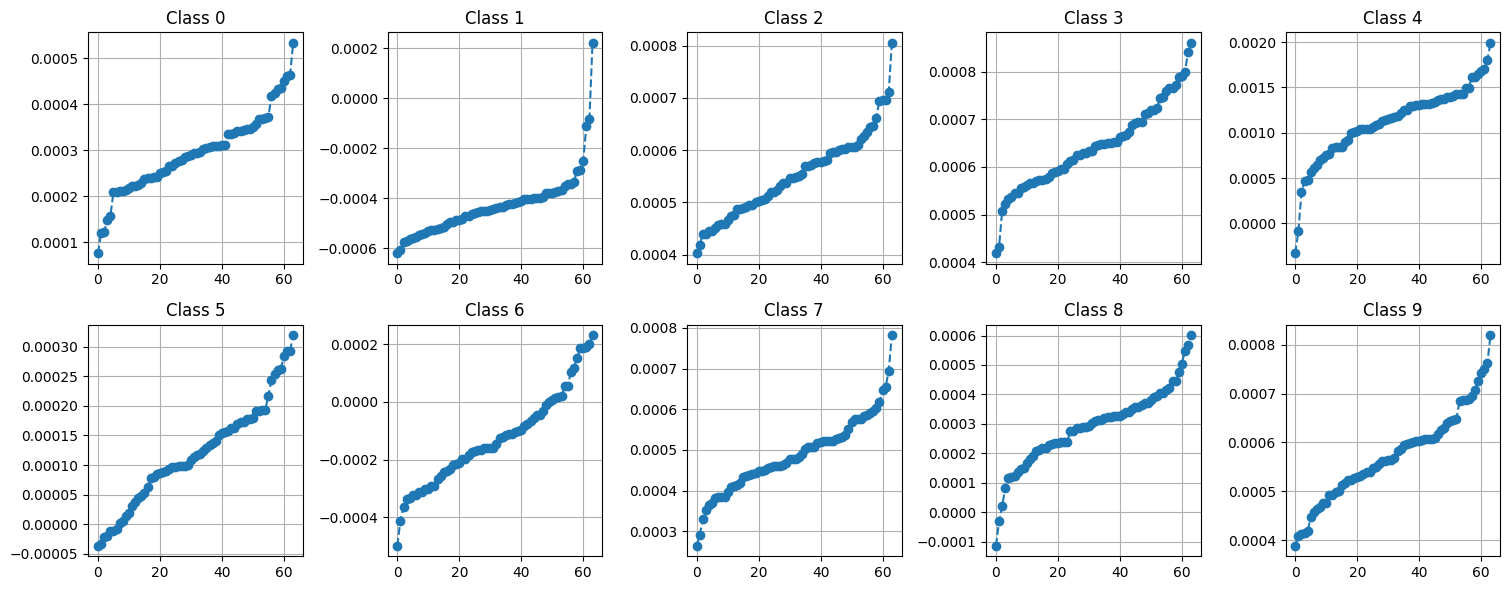

In [6]:
print("Performing inference..")
train_data = torch.as_tensor(normalized_Hermitian_Digit_matrices,dtype = torch.complex128)

train_target = [0]*100 + [1]*100 + [2]*100 + [3]*100 + [4]*100 + [5]*100 + [6]*100 + [7]*100 + [8]*100 + [9]*100

test_data = torch.as_tensor(normalized_hermitian_matrices_test_input,
                               dtype=torch.complex128)
test_target = [0]*20 + [1]*20 + [2]*20 + [3]*20 + [4]*20 + [5]*20 + [6]*20 + [7]*20 + [8]*20 + [9]*20

predicted_labels , train_acc = inference(model,train_data,torch.tensor(training_labels,dtype = torch.long))
print(f"Train Accuracy: {train_acc:.2f}%")

predicted_labels, accuracy = inference(model, test_data, torch.tensor(y_test,dtype = torch.long))
print(f"Test Accuracy: {accuracy:.2f}%")

def visualize_eigenvalues(model):
    with torch.no_grad():
        plt.figure(figsize=(15,6))
        for c in range(10):
            eig = model.eigenvalues[c].cpu().numpy()
            plt.subplot(2,5,c+1)
            plt.plot(np.sort(eig), 'o--')
            plt.title(f'Class {c}')
            plt.grid(True)
        plt.tight_layout()
        plt.show()

visualize_eigenvalues(model)

Approach 2:

In [7]:
# Trainable Mean Hamiltonians of the 10 classes , and then fixing the eigen vectors for each train hamiltonian as mean hamiltonian for that class
# then training the eigen values for each train data to minimize the frobenius norm between the actual train hamiltonian and the reconstructed hamiltonian
# this is the new representation of the train hamiltonian using the Adiabatic Theorem , i.e. perturbing only the eigen values within class and keeping the
# eigen vectors that class found from the whole data in that class as constant in the new representation of the particular hamiltonian

# For Inference we use all the 10 eigen vectors obtained from the train data
# and keep the eigen value matrix as trainable per test hamitonian , to get 10,64,64, hamiltonian representation
# of the test data , and then selecting the class that gives the minimum reconstruction error as the class of the test hamiltonian m
# also instead of this KNN can be used between the 10,64,64 and the reconstructed train hamiltonians per class , and select the class from the list 
# of the forbenius norm per class by majority vote , i.e the class that produce the least KNN formbenius norms...

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader
import numpy as np
import matplotlib.pyplot as plt

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

class_sizes = [5923, 6742, 5958, 6131, 5842, 5421, 5918, 6265, 5851, 5949]  # Must sum to 60000

class ComplexMatrixModel(nn.Module):
    def __init__(self, num_classes=10, matrix_size=64):
        super().__init__()
        self.num_classes = num_classes
        self.matrix_size = matrix_size
        self.class_sizes = class_sizes
        self.eigenvectors = nn.Parameter(
            torch.randn(num_classes, matrix_size, matrix_size, dtype=torch.complex128, device=device)
        )
        self.eigenvalues = nn.Parameter(
            torch.randn(num_classes, matrix_size, dtype=torch.float64, device=device)
        )
        self.class_weights = nn.ParameterList([
            nn.Parameter(torch.randn(size, matrix_size, dtype=torch.float64, device=device))
            for size in self.class_sizes
        ])

    def make_unitary1(self, matrix):
        U, _, Vh = torch.linalg.svd(matrix)
        return U @ Vh

    def make_unitary2(self,matrix):
      Q,R = torch.linalg.qr(matrix)
      return Q

    def make_unitary3(self,matrix):
      matrix = (matrix + matrix.conj().T) / 2
      s = torch.matrix_exp((-1j)*matrix)
      return s

    #CHange 1,2,3
    def forward(self, class_idx=None, batch_indices=None):
        if class_idx is not None:
            return self._generate_class_hamiltonians1(class_idx, batch_indices)
        else:
            all_hams = []
            for idx in range(self.num_classes):
                hams = self._generate_class_hamiltonians1(idx)
                all_hams.append(hams)
            return torch.cat(all_hams, dim=0)

    def _generate_class_hamiltonians1(self, class_idx, batch_indices=None):
        U = self.make_unitary1(self.eigenvectors[class_idx]) 
        eigvals = self.eigenvalues[class_idx]               
        if batch_indices is not None:
            weights = self.class_weights[class_idx][batch_indices]  
        else:
            weights = self.class_weights[class_idx]   

        scaled_eig = weights * eigvals.unsqueeze(0)        
        diag_mats = torch.diag_embed(scaled_eig).to(torch.complex128)  
        U = U.to(torch.complex128)
        U_expanded = U.unsqueeze(0).expand(diag_mats.shape[0], -1, -1) 
        U_conj_T = U_expanded.conj().transpose(-1, -2)               
        H = U_expanded @ diag_mats @ U_conj_T                  
        H_hermitian = (H + H.conj().transpose(-1, -2)) / 2
        return H_hermitian

    def _generate_class_hamiltonians2(self, class_idx, batch_indices=None):
        U = self.make_unitary2(self.eigenvectors[class_idx]) 
        eigvals = self.eigenvalues[class_idx]               
        if batch_indices is not None:
            weights = self.class_weights[class_idx][batch_indices]  
        else:
            weights = self.class_weights[class_idx]   

        scaled_eig = weights * eigvals.unsqueeze(0)        
        diag_mats = torch.diag_embed(scaled_eig).to(torch.complex128)  
        U = U.to(torch.complex128)
        U_expanded = U.unsqueeze(0).expand(diag_mats.shape[0], -1, -1) 
        U_conj_T = U_expanded.conj().transpose(-1, -2)               
        H = U_expanded @ diag_mats @ U_conj_T                  
        H_hermitian = (H + H.conj().transpose(-1, -2)) / 2
        return H_hermitian

    def _generate_class_hamiltonians3(self, class_idx, batch_indices=None):
        U = self.make_unitary3(self.eigenvectors[class_idx]) 
        eigvals = self.eigenvalues[class_idx]               
        if batch_indices is not None:
            weights = self.class_weights[class_idx][batch_indices]  
        else:
            weights = self.class_weights[class_idx]   

        scaled_eig = weights * eigvals.unsqueeze(0)        
        diag_mats = torch.diag_embed(scaled_eig).to(torch.complex128)  
        U = U.to(torch.complex128)
        U_expanded = U.unsqueeze(0).expand(diag_mats.shape[0], -1, -1) 
        U_conj_T = U_expanded.conj().transpose(-1, -2)               
        H = U_expanded @ diag_mats @ U_conj_T                  
        H_hermitian = (H + H.conj().transpose(-1, -2)) / 2
        return H_hermitian

    
    def reconstruct_hamiltonian1(self, class_idx, eigenvalues):
        U = self.make_unitary1(self.eigenvectors[class_idx]).to(torch.complex128)
        d = torch.diag(eigenvalues.to(torch.complex128))
        H = U @ d @ U.conj().T
        H_hermitian = (H + H.conj().T)/2
        return H_hermitian

    def reconstruct_hamiltonian2(self, class_idx, eigenvalues):
        U = self.make_unitary2(self.eigenvectors[class_idx]).to(torch.complex128)
        d = torch.diag(eigenvalues.to(torch.complex128))
        H = U @ d @ U.conj().T
        H_hermitian = (H + H.conj().T)/2
        return H_hermitian

    def reconstruct_hamiltonian3(self, class_idx, eigenvalues):
        U = self.make_unitary3(self.eigenvectors[class_idx]).to(torch.complex128)
        d = torch.diag(eigenvalues.to(torch.complex128))
        H = U @ d @ U.conj().T
        H_hermitian = (H + H.conj().T)/2
        return H_hermitian

def frobenius_loss(output, target):
    return torch.mean(torch.linalg.norm(output - target, dim=(-2, -1)))

def train_model_batched(model, train_data, train_labels, epochs=10, batch_size=256):
    model.train()
    optimizer = optim.Adam(model.parameters(), lr=1e-2)
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, factor=0.5, patience=10)

    train_data = torch.as_tensor(train_data, dtype=torch.complex128)
    train_labels = torch.as_tensor(train_labels, dtype=torch.long)

    train_dataset = TensorDataset(train_data, train_labels)
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

    for epoch in range(epochs):
        total_loss = 0
        batch_count = 0
        for batch_data, batch_labels in train_loader:
            if batch_count % 100 == 0 :
                print(f"Batch:{batch_count}")
            optimizer.zero_grad()
            batch_outputs, batch_targets = [], []
            for class_idx in range(10):
                mask = (batch_labels == class_idx)
                if not mask.any():
                    continue
                sample_idx = torch.where(mask)[0]
                class_sample_idxs = batch_data.new_tensor(
                    [idx.item() for idx in sample_idx], dtype=torch.long, device=device
                )
                class_local_indices = mask.nonzero().flatten()
                class_out = model(class_idx=class_idx, batch_indices=class_local_indices)
                batch_outputs.append(class_out)
                batch_targets.append(batch_data[mask].to(torch.complex128))

            if batch_outputs:
                outputs = torch.cat(batch_outputs, dim=0)
                targets = torch.cat(batch_targets, dim=0)
                loss = frobenius_loss(outputs, targets)
                loss.backward()
                optimizer.step()
                total_loss += loss.item()
                batch_count += 1
        avg_loss = total_loss / max(batch_count, 1)
        scheduler.step(avg_loss)
        if epoch % 1 == 0:
            print(f"Epoch [{epoch+1}/{epochs}] Loss: {avg_loss:.5e}")

def in_range(n, no):
    # Cumulative starting index of each class in the dataset
    class_start = [0, 5923, 12665, 18623, 24754, 30596, 36017, 41935, 48200, 54051]
    
    for start in class_start:
        if start <= n < start + no:
            return True
    return False


#Here change 1,2,3 
import random
def classify_train(model, test_hamiltonians, test_labels,optimize_epochs=20, lr=0.1):
    # class_counts = [5923, 6742, 5958, 6131, 5842, 5421, 5918, 6265, 5851, 5949]
    class_counts = [5923,12665,18623,24754,30596,36017,41935,48200,54051,60000]
        
    model.eval()
    results = []
    with torch.no_grad():
        fixed_eigenvecs = []
        for c in range(10):
            fixed_eigenvecs.append(model.make_unitary1(model.eigenvectors[c]).to(torch.complex128))
    no = 300
    for idx, test_H in enumerate(test_hamiltonians):
        if in_range(idx,no): 
            min_error = float('inf')
            best_class = -1
            test_H = test_H.to(device).to(torch.complex128)
            for class_idx in range(10):
                # Optimize eigenvalues for this test_H and class
                eigvals = model.eigenvalues[class_idx].detach().clone().to(device).requires_grad_(True)
                optimizer = optim.Adam([eigvals], lr=lr)
                for _ in range(optimize_epochs):
                    optimizer.zero_grad()
                    U = fixed_eigenvecs[class_idx]
                    dmat = torch.diag(eigvals.to(torch.complex128))
                    H = U @ dmat @ U.conj().T
                    H_herm = (H + H.conj().T)/2
                    loss = torch.linalg.norm(H_herm - test_H)
                    loss.backward()
                    optimizer.step()
                err = loss.item()
                if err < min_error:
                    min_error = err
                    best_class = class_idx
            results.append(best_class)
            if (idx+1)%50 == 0 or idx < 10:
                print(f"Test {idx+1}/{len(test_hamiltonians)} done, best class: {best_class}, loss: {min_error:.3e}")
    return np.array(results)

#Change 1,2,3
def classify_test(model, test_hamiltonians, test_labels,optimize_epochs=20, lr=0.1):
    # class_counts = [5923, 6742, 5958, 6131, 5842, 5421, 5918, 6265, 5851, 5949]
        
    model.eval()
    results = []
    with torch.no_grad():
        fixed_eigenvecs = []
        for c in range(10):
            fixed_eigenvecs.append(model.make_unitary1(model.eigenvectors[c]).to(torch.complex128))
    for idx, test_H in enumerate(test_hamiltonians):
        if idx < 1000: 
            min_error = float('inf')
            best_class = -1
            test_H = test_H.to(device).to(torch.complex128)
            for class_idx in range(10):
                # Optimize eigenvalues for this test_H and class
                eigvals = model.eigenvalues[class_idx].detach().clone().to(device).requires_grad_(True)
                optimizer = optim.Adam([eigvals], lr=lr)
                for _ in range(optimize_epochs):
                    optimizer.zero_grad()
                    U = fixed_eigenvecs[class_idx]
                    dmat = torch.diag(eigvals.to(torch.complex128))
                    H = U @ dmat @ U.conj().T
                    H_herm = (H + H.conj().T)/2
                    loss = torch.linalg.norm(H_herm - test_H)
                    loss.backward()
                    optimizer.step()
                err = loss.item()
                if err < min_error:
                    min_error = err
                    best_class = class_idx
            results.append(best_class)
            if (idx+1)%50 == 0 or idx < 10:
                print(f"Test {idx+1}/{len(test_hamiltonians)} done, best class: {best_class}, loss: {min_error:.3e}")
    return np.array(results)


def evaluate(pred_labels, true_labels):
    acc = (pred_labels == true_labels.cpu().numpy()).mean()
    print(f"\nTest Accuracy: {acc*100:.2f}%")
    for c in range(10):
        mask = (true_labels.cpu().numpy() == c)
        acc_c = (pred_labels[mask] == c).mean() if mask.sum() > 0 else np.nan
        print(f"Class {c}: {acc_c*100:.2f}% ({mask.sum()} samples)")
    return acc

def visualize_eigenvalues(model):
    with torch.no_grad():
        plt.figure(figsize=(15,6))
        for c in range(10):
            eig = model.eigenvalues[c].cpu().numpy()
            plt.subplot(2,5,c+1)
            plt.plot(np.sort(eig), 'o--')
            plt.title(f'Class {c}')
            plt.grid(True)
        plt.tight_layout()
        plt.show()

# Here instead of Classify Test , KNN can also be used from the train new represented (Trained Eigen Values) Hamitonians and the test new represented Hamiltonians (Trained Eigen Values) per class
def classify_test_knn_eig(model, train_data, train_labels, test_data, case , k=3):
    device = next(model.parameters()).device
    
    # Function to get "new represented" Hamiltonians from trained eigenvalues
    def get_represented_hamiltonians(data, labels):
        represented = []
        for i in range(len(data)):
            if i%1000 == 0 :
                print(i)
            cls = labels[i].item()
            if case == 1:
              U = model.make_unitary1(model.eigenvectors[cls]).to(torch.complex128).to(device)
            elif case == 2:
              U = model.make_unitary2(model.eigenvectors[cls]).to(torch.complex128).to(device)
            else:
              U = model.make_unitary3(model.eigenvectors[cls]).to(torch.complex128).to(device)
            eigvals = model.eigenvalues[cls].detach().to(torch.complex128).to(device)
            H = U @ torch.diag(eigvals) @ U.conj().T
            H = (H + H.conj().T) / 2
            represented.append(H)
        represented = torch.stack(represented)
        return represented

    # Generate represented Hamiltonians
    print("geting represented hamiltonians for training")
    train_repr = get_represented_hamiltonians(train_data, train_labels)
    print("geting represented hamiltonians for testing")
    test_repr = get_represented_hamiltonians(test_data, torch.zeros(len(test_data), dtype=torch.long))

    # Flatten to vectors for KNN
    X_train = train_repr.reshape(len(train_repr), -1).real.cpu().numpy()
    X_test = test_repr.reshape(len(test_repr), -1).real.cpu().numpy()
    y_train = train_labels.cpu().numpy()

    # Fit KNN
    print("training the KNN model....")
    knn = KNeighborsClassifier(n_neighbors=k, metric='euclidean')
    knn.fit(X_train, y_train)

    # Predict
    print("Predicting....")
    predictions = knn.predict(X_test)
    return predictions


Using device: cpu


In [8]:
def create_labels_from_class_counts(class_counts):
    labels = []
    for class_idx, count in enumerate(class_counts):
        labels.extend([class_idx] * count)
    return labels

def create_batched_data(data, labels, batch_size=64):
    if not isinstance(data, torch.Tensor):
        if isinstance(data, list) and len(data) > 0:
            data = torch.stack(data)
        else:
            data = torch.tensor(data)
    if not isinstance(labels, torch.Tensor):
        labels = torch.tensor(labels)
    if not data.dtype == torch.complex128:
        data = data.to(torch.complex128)
    dataset = TensorDataset(data, labels)
    dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)
    
    return dataloader


class_counts = [5923, 6742, 5958, 6131, 5842, 5421, 5918, 6265, 5851, 5949]
train_hamiltonians = normalized_Hermitian_Digit_matrices
train_labels = create_labels_from_class_counts(class_counts)
test_hamiltonians = normalized_hermitian_matrices_test_input
test_labels = y_test

model = ComplexMatrixModel(num_classes=10, matrix_size=64).to(device)
print("Model Instantiated.")

print("----- TRAINING PHASE -----")
train_model_batched(model, train_hamiltonians, np.array(train_labels), epochs=20, batch_size=600)



Model Instantiated.
----- TRAINING PHASE -----
Batch:0
Epoch [1/20] Loss: 4.89807e+00
Batch:0
Epoch [2/20] Loss: 1.65219e+00
Batch:0
Epoch [3/20] Loss: 9.84277e-01
Batch:0
Epoch [4/20] Loss: 8.54919e-01
Batch:0
Epoch [5/20] Loss: 7.73963e-01
Batch:0
Epoch [6/20] Loss: 7.04917e-01
Batch:0
Epoch [7/20] Loss: 6.44220e-01
Batch:0
Epoch [8/20] Loss: 5.89671e-01
Batch:0
Epoch [9/20] Loss: 5.39468e-01
Batch:0
Epoch [10/20] Loss: 4.93607e-01
Batch:0
Epoch [11/20] Loss: 4.50958e-01
Batch:0
Epoch [12/20] Loss: 4.10908e-01
Batch:0
Epoch [13/20] Loss: 3.74370e-01
Batch:0
Epoch [14/20] Loss: 3.38966e-01
Batch:0
Epoch [15/20] Loss: 3.06766e-01
Batch:0
Epoch [16/20] Loss: 2.78428e-01
Batch:0
Epoch [17/20] Loss: 2.50537e-01
Batch:0
Epoch [18/20] Loss: 2.26789e-01
Batch:0
Epoch [19/20] Loss: 2.04943e-01
Batch:0
Epoch [20/20] Loss: 1.87807e-01


In [9]:
print("----- CLASSIFICATION ON TEST -----")
print("Train prediction")
pred_labels_train = classify_train(model,train_hamiltonians,torch.tensor(train_labels,dtype = torch.long),optimize_epochs=20,lr = 0.1)
print("test prediction")
pred_labels_test = classify_test(model, test_hamiltonians, torch.tensor(test_labels[:1000],dtype = torch.long), optimize_epochs=20, lr=0.1)  
#pred_labels_test = classify_test_knn_eig(model,torch.tensor(train_hamiltonians,dtype = torch.complex128),torch.tensor(train_labels,dtype = torch.long) ,torch.tensor(test_hamiltonians,dtype = torch.complex128),1,k=3)



----- CLASSIFICATION ON TEST -----
Train prediction
Test 1/60000 done, best class: 2, loss: 2.242e-01
Test 2/60000 done, best class: 2, loss: 2.244e-01
Test 3/60000 done, best class: 2, loss: 2.248e-01
Test 4/60000 done, best class: 2, loss: 2.246e-01
Test 5/60000 done, best class: 2, loss: 2.242e-01
Test 6/60000 done, best class: 2, loss: 2.241e-01
Test 7/60000 done, best class: 2, loss: 2.244e-01
Test 8/60000 done, best class: 2, loss: 2.234e-01
Test 9/60000 done, best class: 2, loss: 2.245e-01
Test 10/60000 done, best class: 2, loss: 2.247e-01
Test 50/60000 done, best class: 2, loss: 2.239e-01
Test 100/60000 done, best class: 2, loss: 2.243e-01
Test 150/60000 done, best class: 2, loss: 2.236e-01
Test 200/60000 done, best class: 2, loss: 2.239e-01
Test 250/60000 done, best class: 2, loss: 2.244e-01
Test 300/60000 done, best class: 2, loss: 2.239e-01
Test 5950/60000 done, best class: 2, loss: 2.236e-01
Test 6000/60000 done, best class: 2, loss: 2.245e-01
Test 6050/60000 done, best cla

In [10]:
print("----- ACCURACY -----")
temp_train_labels = np.array([0]*300 + [1]*300 + [2]*300 + [3]*300 + [4]*300 + [5]*300 + [6]*300 + [7]*300 + [8]*300 + [9]*300)
# temp_test_labels = np.array([0]*20 + [1]*20 + [2]*20 + [3]*20 + [4]*20 + [5]*20 + [6]*20 + [7]*20 + [8]*20 + [9]*20)
train_accuracy = evaluate(pred_labels_train, torch.tensor(temp_train_labels,dtype = torch.long))
test_accuracy = evaluate(pred_labels_test, torch.tensor(y_test[:1000],dtype = torch.long))
print(f"Train accuracy: {train_accuracy}")
print(f"Test accuracy: {test_accuracy}")

----- ACCURACY -----

Test Accuracy: 10.00%
Class 0: 0.00% (300 samples)
Class 1: 0.00% (300 samples)
Class 2: 100.00% (300 samples)
Class 3: 0.00% (300 samples)
Class 4: 0.00% (300 samples)
Class 5: 0.00% (300 samples)
Class 6: 0.00% (300 samples)
Class 7: 0.00% (300 samples)
Class 8: 0.00% (300 samples)
Class 9: 0.00% (300 samples)

Test Accuracy: 30.20%
Class 0: 61.18% (85 samples)
Class 1: 41.27% (126 samples)
Class 2: 49.14% (116 samples)
Class 3: 23.36% (107 samples)
Class 4: 28.18% (110 samples)
Class 5: 3.45% (87 samples)
Class 6: 10.34% (87 samples)
Class 7: 9.09% (99 samples)
Class 8: 58.43% (89 samples)
Class 9: 12.77% (94 samples)
Train accuracy: 0.1
Test accuracy: 0.302
